In [2]:
# imports wichtiger Module

import pandas as pd
import numpy as np

In [2]:
# Einlesen des Datensatzes + Säuberung

df = pd.read_csv("../data/pokedex.csv")
df.index = df['Unnamed: 0']
df.index.name = 'Index'
df = df.drop(columns=['Unnamed: 0'])
df = df.astype({'status': 'category', 'species': 'category', 'type_1': 'category', 'type_2': 'category'})

In [3]:
# Jupyter Notebook Einstellungen

pd.set_option('display.max_columns', df.shape[1])
from IPython.display import display

# Numerische Datenanalyse

## Fehlende Werte

Bevor wir beginnen nun etwas tiefer in die Beantwortung unserer Frage **"Welches ist das stärkste Pokemon?"** einzutauchen, sollten wir unseren Datensatz erst einmal darauf überprüfen, ob wir alle nötigen Werte haben, oder ob einige fehlen (Stichwort "missing values").

Hier helfen die Funktionen `.isna()` und `.isnull()` die absolut das gleiche tun! Welche Funktion sie aufrufen ist *Geschmackssache*. Die Tatsache, dass es zwei Namen für die selbe Funktion gibt rührt daher, dass man es Menschen, die z.B. aus der R-Welt kommen, es leichter machen wollte. Python Programmierer:innen können dabei aber wohl mehr mit `null` als mit `na` anfangen.

In [4]:
test = pd.Series([2, 3, pd.NA, True, False, 0])

test

0        2
1        3
2     <NA>
3     True
4    False
5        0
dtype: object

In [5]:
test.isna()

0    False
1    False
2     True
3    False
4    False
5    False
dtype: bool

In [6]:
test.isna().sum()

1

Die Methode `.sum()` werden wir gleich noch kennen lernen, aber ich glaube, sie ist selbsterklärend. Wir zählen einfach die `True` Werte, welche intern als die Zahl "1" zählen. In unserem Test-Beispiel gibt es also genau *einen* fehlenden Wert. Dies können wir uns zunutze machen, indem wir `.isna()` auf unseren gesamten DataFrame anwenden und die `True` Werte zählen. So bekommen wir für jede Variable die Anzahl an fehlenden Werten.

In [7]:
df.isna().sum()

pokedex_number        0
name                  0
german_name           0
japanese_name         0
generation            0
status                0
species               0
type_number           0
type_1                0
type_2              492
height_m              0
weight_kg             1
abilities_number      0
ability_1             3
ability_2           529
ability_hidden      232
total_points          0
hp                    0
attack                0
defense               0
sp_attack             0
sp_defense            0
speed                 0
catch_rate           18
base_friendship     115
base_experience     120
growth_rate           1
egg_type_number       0
egg_type_1            3
egg_type_2          760
percentage_male     173
egg_cycles            1
against_normal        0
against_fire          0
against_water         0
against_electric      0
against_grass         0
against_ice           0
against_fight         0
against_poison        0
against_ground        0
against_flying  

Für die Fragen, die wir beantworten wollen, sieht es schon einmal gut aus. Bei bestimmten Variablen sind fehlende Werte verständlich (nicht alle Pokemon haben z.B. einen zweiten Typ), bei anderen Variablen, wie 'growth_rate' oder 'egg_cycles' ist es uns nicht so wichtig. Wir können aber dennoch einmal der Veranschaulichung halber sehen, bei welchen Pokemon die 'growth_rate' fehlt.

In [8]:
no_growth_rate = df['growth_rate'].isna()

df[no_growth_rate][['pokedex_number', 'name']]

,pokedex_number,name
Index,,
658,555,Galarian Darmanitan Zen Mode


## Finde das stärkste Pokemon

Wann gehört ein Pokemon zu den Stärksten? Natürlich dann, wenn es sich mit anderen Pokemon messen kann. Und wie messen sich Pokemon? Klar! Sie kämpfen gegeneinander.

Im nachfolgenden werden wir einen Datensatz mit 50.000 Pokemon Kämpfen einlesen und die Gewinnrate der einzelnen Pokemon berechnen. Der Datensatz befindet sich unter `/data/combats.csv`.

In [9]:
# Einlesen des Datensatzes

df_combat = pd.read_csv("../data/combats.csv")

In [10]:
# einen Überblick verschaffen

df_combat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49161 entries, 0 to 49160
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Unnamed: 0      49161 non-null  int64
 1   First_pokemon   49161 non-null  int64
 2   Second_pokemon  49161 non-null  int64
 3   Winner          49161 non-null  int64
dtypes: int64(4)
memory usage: 1.5 MB


In [11]:
# es gibt eine überflüssige Spalte - werden wir sie los!

df_combat = df_combat.iloc[:, 1:] # anstatt wie sonst die .drop() Methode zu benutzen,
                                  # filtern wir den Datensatz und überschreiben ihn
df_combat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49161 entries, 0 to 49160
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   49161 non-null  int64
 1   Second_pokemon  49161 non-null  int64
 2   Winner          49161 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


In [12]:
df_combat.head()

,First_pokemon,Second_pokemon,Winner
0,246,274,274
1,640,639,639
2,176,606,606
3,218,621,621
4,139,213,139


Wie wir sehen, sind hier die Pokedex Nummern der jeweiligen Kontrahenten verzeichnet, sowie der/die Gewinner:in.

Um die **Gewinnrate** zu berechnen, brauchen wir die Anzahl je Pokemon, wie oft es zu einem Kampf angetreten ist und wie oft es gewonnen hat. Wir teilen dann die Anzahl der Siege durch die Anzahl an Kämpfe je Pokemon.

### Exkurs 1: arithmetische Operatoren und NumPy Arrays

Würden wir obige Aufgabe mit reinem Python Code schreiben wollen, so müssten wir im wahrsten Sinne des Wortes einige Schleifen drehen, also `while`- oder `for`-loops einbauen. Nicht so gedoch mit NumPy Datenstrukturen. Hier kann man mathematische Operationen einfach auf zwei Arrays anwenden und NumPy wird diese Operation im Hintergrund auf jedes Element der Arrays anwenden.

Sehen wir uns einfach folgende Beispiele an:

In [13]:
arr_1 = np.array([2, 4, 6, 8, 10])

arr_2 = np.array([5, 7, 9, 11, 13])

In [14]:
arr_1 + arr_2

array([ 7, 11, 15, 19, 23])

In [15]:
arr_2 / arr_1

array([2.5  , 1.75 , 1.5  , 1.375, 1.3  ])

In [16]:
arr_1 - arr_2

array([-3, -3, -3, -3, -3])

In [17]:
arr_1 * arr_2

array([ 10,  28,  54,  88, 130])

![Array Arithmetik](../imgs/array_arithmetic.png)

### pd.Series Arithmetik und Index

Da, wie wir nun ja jetzt wissen, dass Pandas Series Objekte auf NumPy Arrays aufbauen, aber einen Index haben, können wir uns über das mathematische Verhalten von NumPy Arrays zusammen mit dem Index einen enormen Vorteil gegenüber "Standard Python Code" verschaffen.

Wendet man mathematische Operationen auf zwei Series Objekte an, so versucht Pandas im Hintergrund diese Objekte anhand der Indices und nicht anhand der Reihenfolge der Elemente zu matchen.

Schauen wir uns wieder ein Beispiel an:

In [18]:
area = pd.Series({'Alaska': 1723337, 'Texas': 695662,
                  'California': 423967})

area

Alaska        1723337
Texas          695662
California     423967
dtype: int64

In [19]:
population = pd.Series({'California': 38332521, 'Texas': 26448193,
                        'New York': 19651127})

population

California    38332521
Texas         26448193
New York      19651127
dtype: int64

In [20]:
population / area

Alaska              NaN
California    90.413926
New York            NaN
Texas         38.018740
dtype: float64

Wie wir sehen, führt Pandas die Rechenoperation anhand der Indices aus. Da aber im Objekt `area` die Fläche von "New York" fehlt und im Objekt `population` die Bevölkerung von "Alaska", wird bei diesen Staaten `NaN` (**N**ot **a N**umber), also "fehlender Wert" zurückgegeben.

Dieses Verhalten können wir nun in Kombination mit einer weiteren Pandas Funktion nutzen.

### Werte zählen mit .value_counts()

Sowohl ein Pandas DataFrame, als auch ein Pandas Series Objekt besitzen die Methode `.value_counts()`. Diese Funktion erklärt man am besten anhand eines Beispiels:

In [21]:
pokemon_to_choose_from = ['Pikachu', 'Kecleon', 'Kapu-Kime', 'Sniebel', 'Ampharos']

choices = np.random.choice(pokemon_to_choose_from, size=100, p=[0.4, 0.2, 0.2, 0.1, 0.1])

wins = pd.Series(choices)

wins.value_counts()

Pikachu      48
Kecleon      25
Kapu-Kime    13
Ampharos      9
Sniebel       5
dtype: int64

`.value_counts()` gibt also ein Series Objekt zurück dessen Index die Namen der einzigartigen Werte im ursprünglichen DataFrame/Series Objekt darstellt und die Values der Series sind die summierten Werte des Ursprung-DataFrames/Series Objekts.

**Zählen wir also nun, wie oft ein Pokemon angetreten ist.**

Da dies in unserem Datensatz sowohl in der Spalte `'First_pokemon'` als auch in der Spalte `'Second_pokemon'` sein kann, müssen wir beide zählen und dann addieren.

In [22]:
counts_1 = df_combat['First_pokemon'].value_counts()
counts_2 = df_combat['Second_pokemon'].value_counts()

counts_1

479    366
711    254
150    217
386    205
6      189
      ... 
453     44
243     43
588     42
458     42
604     42
Name: First_pokemon, Length: 705, dtype: int64

In [23]:
combats = counts_1 + counts_2

combats

1      133
2      121
3      256
4      110
5      116
      ... 
715    115
716    129
717    136
719    235
721    121
Length: 705, dtype: int64

Die Ausgabe von `combats` ist also folgendermaßen zu interpretieren:

Das Pokemon mit der Pokedexnummer 1 hat 133 mal gekämpft, das Pokemon mit der Pokedexnummer 2 hat 121 mal gekämpft usw.

Nun können wir auch die "wins" zählen und diese dann durch "combats" teilen. So erhalten wir ein Pandas Series Objekt, dessen Index die Pokedexnummer darstellt und deren Werte die Win-Rate sind.

In [24]:
wins = df_combat['Winner'].value_counts()

In [25]:
win_rate = wins / combats

win_rate

1      0.278195
2      0.380165
3      0.617188
4      0.490909
5      0.543103
         ...   
715    0.930435
716    0.829457
717    0.808824
719    0.659574
721    0.619835
Length: 705, dtype: float64

Nun können wir das ganze noch sortieren, damit wir sofort die besten und schlechtesten Pokemon in einem Blick erfassen können. Da es sich aber um Pokedexnummern handelt, wollen wir unseren ursprünglichen Pokemon Datensatz auf die besten 5 und die schlechtesten 5 Pokemon filtern.

In [26]:
win_rate.sort_values(ascending=False)

142    0.973783
461    0.973684
658    0.968254
243    0.947368
493    0.942149
         ...   
218    0.032787
577    0.031008
175    0.024793
266    0.021739
213         NaN
Length: 705, dtype: float64

In [27]:
# die Top 5 Pokemon

top_5_dex_nums = win_rate.sort_values(ascending=False).iloc[:5]

top_5_dex_nums_mask = df['pokedex_number'].isin(top_5_dex_nums.index.to_list())

df[top_5_dex_nums_mask]

,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,abilities_number,ability_1,ability_2,ability_hidden,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,growth_rate,egg_type_number,egg_type_1,egg_type_2,percentage_male,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fight,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
181,142,Aerodactyl,Aerodactyl,プテラ (Ptera),1,Normal,Fossil Pokémon,2,Rock,Flying,1.8,59.0,3,Rock Head,Pressure,Unnerve,515,80,105,65,60,75,130,45.0,70.0,180.0,Slow,1,Flying,NaN,87.5,35.0,0.5,0.5,2.0,2.0,1.0,2.0,1.0,0.5,0.0,0.5,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0
182,142,Mega Aerodactyl,Aerodactyl,プテラ (Ptera),1,Normal,Fossil Pokémon,2,Rock,Flying,2.1,79.0,1,Tough Claws,NaN,NaN,615,80,135,85,70,95,150,45.0,70.0,215.0,Slow,1,Flying,NaN,87.5,35.0,0.5,0.5,2.0,2.0,1.0,2.0,1.0,0.5,0.0,0.5,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0
295,243,Raikou,Raikou,ライコウ (Raikou),2,Sub Legendary,Thunder Pokémon,1,Electric,NaN,1.9,178.0,2,Pressure,NaN,Inner Focus,580,90,85,75,115,100,115,3.0,35.0,261.0,Slow,1,Undiscovered,NaN,NaN,80.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
550,461,Weavile,Snibunna,マニューラ (Manyula),4,Normal,Sharp Claw Pokémon,2,Dark,Ice,1.1,34.0,2,Pressure,NaN,Pickpocket,510,70,120,65,45,85,125,45.0,35.0,179.0,Medium Slow,1,Field,NaN,50.0,20.0,1.0,2.0,1.0,1.0,1.0,0.5,4.0,1.0,1.0,1.0,0.0,2.0,2.0,0.5,1.0,0.5,2.0,2.0
590,493,Arceus,Arceus,アルセウス (Arceus),4,Mythical,Alpha Pokémon,1,Normal,NaN,3.2,320.0,1,Multitype,NaN,NaN,720,120,120,120,120,120,120,3.0,0.0,324.0,Slow,1,Undiscovered,NaN,NaN,120.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
770,658,Greninja,Quajutsu,ゲッコウガ (Gekkouga),6,Normal,Ninja Pokémon,2,Water,Dark,1.5,40.0,2,Torrent,NaN,Protean,530,72,95,67,103,71,122,45.0,70.0,239.0,Medium Slow,1,Water 1,NaN,87.5,20.0,1.0,0.5,0.5,2.0,2.0,0.5,2.0,1.0,1.0,1.0,0.0,2.0,1.0,0.5,1.0,0.5,0.5,2.0
771,658,Ash-Greninja,Quajutsu,ゲッコウガ (Gekkouga),6,Normal,Ninja Pokémon,2,Water,Dark,1.5,40.0,1,Battle Bond,NaN,NaN,640,72,145,67,153,71,132,45.0,70.0,288.0,Medium Slow,1,Undiscovered,NaN,100.0,20.0,1.0,0.5,0.5,2.0,2.0,0.5,2.0,1.0,1.0,1.0,0.0,2.0,1.0,0.5,1.0,0.5,0.5,2.0


In [28]:
# die worst 5 Pokemon

worst_5_dex_nums = win_rate.sort_values(ascending=True, na_position='first').iloc[:5]

worst_5_dex_nums_mask = df['pokedex_number'].isin(worst_5_dex_nums.index.to_list())

df[worst_5_dex_nums_mask]

,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,abilities_number,ability_1,ability_2,ability_hidden,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,growth_rate,egg_type_number,egg_type_1,egg_type_2,percentage_male,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fight,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
220,175,Togepi,Togepi,トゲピー (Togepy),2,Normal,Spike Ball Pokémon,1,Fairy,NaN,0.3,1.5,3,Hustle,Serene Grace,Super Luck,245,35,20,65,40,65,20,190.0,70.0,49.0,Fast,1,Undiscovered,NaN,87.5,10.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,1.0,1.0,0.0,0.5,2.0,1.0
262,213,Shuckle,Pottrott,ツボツボ (Tsubotsubo),2,Normal,Mold Pokémon,2,Bug,Rock,0.6,20.5,3,Sturdy,Gluttony,Contrary,505,20,10,230,10,230,5,190.0,70.0,177.0,Medium Slow,1,Bug,NaN,50.0,20.0,0.5,1.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0
268,218,Slugma,Schneckmag,マグマッグ (Magmag),2,Normal,Lava Pokémon,1,Fire,NaN,0.7,35.0,3,Magma Armor,Flame Body,Weak Armor,250,40,40,40,70,40,20,190.0,70.0,50.0,Medium Fast,1,Amorphous,NaN,50.0,20.0,1.0,0.5,2.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
324,266,Silcoon,Schaloko,カラサリス (Karasalis),3,Normal,Cocoon Pokémon,1,Bug,NaN,0.6,10.0,1,Shed Skin,NaN,NaN,205,50,35,55,25,25,15,120.0,70.0,72.0,Medium Fast,1,Bug,NaN,50.0,15.0,1.0,2.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
681,577,Solosis,Monozyto,ユニラン (Uniran),5,Normal,Cell Pokémon,1,Psychic,NaN,0.3,1.0,3,Overcoat,Magic Guard,Regenerator,290,45,30,40,105,50,20,200.0,70.0,58.0,Medium Slow,1,Amorphous,NaN,50.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,2.0,1.0,2.0,1.0,2.0,1.0,1.0


## Zwischenspiel: Pokemons sichtbar machen

Eigentlich wäre es schön, wenn wir nicht nur die Namen bestimmter Pokemon hätten sondern uns auch ein Bild von diesen Pokemon machen könnten.

Zum Glück gibt es im Internet Datenbanken, die den öffentlichen Zugriff erlauben und aus denen man die Darstellungen der Pokemon als Bilddateien herunterladen kann.

Einer dieser Datenbanken ist [pokeapi.co](https://pokeapi.com), auf die man per [REST API](https://de.wikipedia.org/wiki/Representational_State_Transfer) zugreifen kann. Man bekommt dann ein sog. JSON Element zurück, in dem viele Werte von Pokemon gespeichert sind, unter anderem auch eine Bild-URL. Diese URL wollen wir nutzen, um das Bild herunterzuladen und mit der IPython eigenen Funktion `Image()` anzuzeigen.

In [5]:
import requests
from IPython.display import Image

def get_poke_image(pokedex_num):
    api_url = "https://pokeapi.co/api/v2/pokemon/" + str(pokedex_num) + "/"
    response = requests.request(url=api_url, method="GET")
    json_stats = response.json()
    return json_stats["sprites"]["front_default"]

Testen wir diese neue Funktion doch einmal mit dem besten und dem schlechtesten Pokemon.

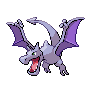

In [30]:
# Das beste Pokemon war Aerodactyl mit der Pokedexnummer 142

Image(get_poke_image(142))

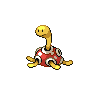

In [31]:
# Das schlechteste Pokemon mit null Gewinnen war Shuckle (213)

Image(get_poke_image(213))

## Die Win-Rate zu unserem Datensatz hinzufügen

Um zwei DataFrames mit einander zu verbinden, bedienen wir uns der Funktion `.merge()`. Die Art und Weise, wie diese Funktion funktioniert ist dabei sehr an die Sprache [SQL](https://de.wikipedia.org/wiki/SQL) für [relationale Datenbanken](https://de.wikipedia.org/wiki/Relationale_Datenbank) angelegt; dabei meine ich nicht so sehr die Syntax, als die *Denkweise* von SQL.

Da Ihnen diese Denkweise vielleicht etwas fremd ist, werde ich sie hier kurz erklären.

Möchte man in SQL *zwei* Tabellen einer Datenbank miteinander verknüpfen, als einen sog. *Join* machen, betrachtet man die Inhalte der Tabellen wie zwei Mengen (im mathematischen Sinn), die man auf vier unterschiedliche Weise verknüpfen kann. Diese Weisen der Verknüpfung lassen sich auch in sog. [Venn Diagrammen](https://de.wikipedia.org/wiki/Mengendiagramm) darstellen. Bei der Darstellung mit Venn Diagrammen von der Verknüpfung von genau *zwei* Mengen gibt es immer eine *linke* Seite, eine *rechte* Seite, einen *inneren* Bereich und einen *äuẞeren* Bereich. Dies sind dann auch genau die vier Grundarten (es gibt noch ein paar speziellere aber weniger wichtige Arte), wie sich in SQL Tabellen miteinander verbinden lassen. Dementsprechend spricht man von einem *left*, einem *right*, einem *inner* und einem *outer* Join.

Folgende Schaubilder mögen das veranschaulichen:

![Inner Join](../imgs/inner_join.png)

![Left Join](../imgs/left_join.png)

![Right Join](../imgs/right_join.png)

![Outer Join](../imgs/outer_join.png)

Genau in diesem "Duktus" verfährt nun auch `.merge()`. Man ruft `.merge()` **immer**(!) auf dem *linken* Datensatz auf. Der DataFrame, mit dem `.merge()` aufgerufen wird, ist also unsere *linke Seite*.

```
<df_links>.merge()
```

So dann müssen wir aber auch die *rechte Seite* angeben. Dies erfolgt sinnigerweise über den Parameter "right".

```
<df_links>.merge(right=<df_rechts>)
```

Als nächstes geben wir an, *wie* gejoint werden soll: also *inner*, *left*, *right* oder *outer*. Default, wenn nichts angegeben wird ist immer *inner* (**Achtung** bei dieser Auswahl verlieren Sie unter Umständen wichtige Daten!).

```
<df_links>.merge(right=<df_rechts>, how=<join_methode>)
```

Aber was sind nun die Spalten, auf die abgeglichen werden soll. In unserem obigen Beispiel ist dies ja in beiden Tabellen die Spalte "ID" gewesen. Aber die Spalte kann ja in unterschiedlichen Datensätzen anders heiẞen. Oder im einen Datensatz ist es eine Spalte, im anderen aber ein Index. Mit den Parametern "left_on" und "right_on" geben wir die Spalte im *linken*, respektive im *rechten* Datensatz an.

```
<df_l>.merge(right=<df_r>, how=<join_m>, left_on=<linke_spalte>, right_on=<rechte_spalte>)
```

Damit wäre der Funktionsaufruf vollständig und wir können ihn auf unser Problem und unsere Datensätze `df` und `win_rate` anwenden.

In [32]:
# unsere Pandas Series hatte noch gar keinen Namen,
# dieser ist aber nötig für einen merge - Pandas "beschwert" sich sonst

win_rate.name = 'win_rate'

In [33]:
df = df.merge(right=win_rate, how='left', left_on='pokedex_number', right_on=win_rate.index)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1044
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   pokedex_number    1045 non-null   int64   
 1   name              1045 non-null   object  
 2   german_name       1045 non-null   object  
 3   japanese_name     1045 non-null   object  
 4   generation        1045 non-null   int64   
 5   status            1045 non-null   category
 6   species           1045 non-null   category
 7   type_number       1045 non-null   int64   
 8   type_1            1045 non-null   category
 9   type_2            553 non-null    category
 10  height_m          1045 non-null   float64 
 11  weight_kg         1044 non-null   float64 
 12  abilities_number  1045 non-null   int64   
 13  ability_1         1042 non-null   object  
 14  ability_2         516 non-null    object  
 15  ability_hidden    813 non-null    object  
 16  total_points      1045 n

## Was ist das beste Element?

Gibt es im Spiel Pokemon ein Element, das alle anderen überragt, das am meisten Vorteile gegenüber anderen Elemente bietet, oder das generell mehr Angriffs- und Verteidigungswerte aufweist? Oder ist es das, das in den Simulationen einfach am häufigsten gewonnen hat? Diese Fragen betreffen das **Balancing** des Spiels: ist das Spiel ausgeglichen oder erhöht die Wahl des Pokemons eines bestimmten Elements alleine schon die Gewinnchance?

Beginnen wir mit der Frage: "Gibt es ein Element, das weniger Nachteile gegenüber den anderen Elementen hat als andere?" Was müssen wir tun, um diese Frage zu beantworten? Wir könnten eine Matrix erstellen das für jedes Element den durchschnittlichen Nachteil gegenüber anderen Elementen angibt. In unserem Datensatz befindet sich für jedes Pokemon der Nachteil als *Multiplikationsfaktor* in den Spalten `against_…`.

Das Pokemon "Bisasam" vom Elementtyp "Grass" hat z.B. einen Nachteil von 2 gegenüber Feuer Elementen (muss also doppelten Schaden einstecken), aber nur einen Nachteil von 0.5 gegenüber Wasser Elementen (halbiert also deren Schaden).

In [35]:
df[df['german_name'] == 'Bisasam'][['german_name', 'against_fire', 'against_water']]

,german_name,against_fire,against_water
0,Bisasam,2.0,0.5


### Aggregatsfunktionen

Wir wollen nun den Mittelwert jedes Elements für jede Variable `against_…` ermitteln. Dies können wir in Pandas sehr leicht durch sog. Aggregatsfunktionen, Funktionen also, die einen numerischen Wert (wie die z.B. die Summe) über eine Menge an Werten berechnet.

Wir können diese Aggregatsfunktionen als Methoden direkt an einem DataFrame oder an einem Series Objekt aufrufen. Rufen wir sie an einer Series auf, so werden einfach die Werte der Series aggregiert. Rufen wir sie aber auf einem DataFrame auf und geben die Achse mit an, über die aggregiert werden soll, so werden alle Werte pro Spalte (Achse 1) oder pro Zeile (Achse 0) aggregiert.

Die wichtigsten Aggregatsfunktionen sind:

| **Name** | **Beschreibung** |
|:---|:---|
| `.sum()` | berechnet die *Summe* |
| `.min()` | berechnet das *Minimum* |
| `.max()` | berechnet das *Maximum* |
| `.mean()` | berechnet den *Mittelwert* |
| `.median()` | berechnet den *Median* |
| `.var()` | berechnet die *Varianz* |
| `.std()` | berechnet die *Standardabweichung* |
| `.sem()` | berechnet den *Standardfehler* |
| `.quantile()` | berechnet das angegebene *Quantil* |
| `.cov()` | berechnet die paarweise *Kovarianz* (nur DF!) |
| `.corr()` | berechnet die paarweise *Korrelation* (nur DF!) |


Ein paar Beispielfragen sollen das verdeutlichen.

In [36]:
# Welche(s) Pokemon haben/hat die meisten HP (health point = Lebenspunkte)?

max_hp = df['hp'].max()
print("Max HP: ", max_hp)
df[df['hp'] == max_hp]

Max HP:  255


,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,abilities_number,ability_1,ability_2,ability_hidden,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,...,growth_rate,egg_type_number,egg_type_1,egg_type_2,percentage_male,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fight,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,win_rate
294,242,Blissey,Heiteira,ハピナス (Happinas),2,Normal,Happiness Pokémon,1,Normal,NaN,1.5,46.8,3,Natural Cure,Serene Grace,Healer,540,255,10,10,75,135,55,30.0,140.0,...,Fast,1,Fairy,NaN,0.0,40.0,1.0,1.0,1.0,1.0,1.00,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.314961
1033,890,Eternatus Eternamax,Endynalos,ムゲンダイナ (Mugendina),8,Legendary,Gigantic Pokémon,2,Poison,Dragon,100.0,NaN,0,NaN,NaN,NaN,1125,255,115,250,125,250,130,NaN,NaN,...,Slow,1,Undiscovered,NaN,NaN,120.0,1.0,0.5,0.5,0.5,0.25,2.0,0.5,0.5,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,1.0,1.0,NaN


In [37]:
# Wie viel Kg wiegt ein Pokemon durchschnittlich? Wie groẞ in Metern ist es durchschnittlich?

df[['weight_kg', 'height_m']].mean()

weight_kg    71.216571
height_m      1.374067
dtype: float64

In [38]:
# Was sind die Mittelwerte, Mediane, Standardabweichungen und Standardfehler
# der Kampfwerte hp, attack, defense, sp_attack, sp_defense und speed?

for el in ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']:
    print('\n', el.upper(), '\n-------------------------')
    print(' My: ', df[el].mean())
    print('Med: ', df[el].median())
    print('Std: ', df[el].std())
    print(' SE: ', df[el].sem())


 HP 
-------------------------
 My:  70.06794258373206
Med:  68.0
Std:  26.67141078627136
 SE:  0.8250643897331725

 ATTACK 
-------------------------
 My:  80.47655502392344
Med:  77.0
Std:  32.43272842636341
 SE:  1.0032873589218991

 DEFENSE 
-------------------------
 My:  74.67081339712918
Med:  70.0
Std:  31.25946231928833
 SE:  0.9669930626664198

 SP_ATTACK 
-------------------------
 My:  73.03157894736842
Med:  65.0
Std:  32.7458569502884
 SE:  1.012973805453374

 SP_DEFENSE 
-------------------------
 My:  72.29856459330144
Med:  70.0
Std:  28.09894340616741
 SE:  0.8692242708619573

 SPEED 
-------------------------
 My:  68.80765550239235
Med:  65.0
Std:  30.210093508068866
 SE:  0.9345314563130183


-------------
#### Exkurs 2: For-Schleifen in Python

Eine Sequenz von Elementen zeichnet sich dadurch aus, dass man über sie *iterieren* kann, d.h. dass man nacheinander jedes Element in Folge ansprechen kann. Daher nennt man Sequenzen in Python auch *iterables*, also iterierbare Objekte.

Möchte man in Python über eine Sequenz iterieren, also jedes Element darin nacheinander ansprechen und vielleicht etwas mit diesem Element machen, so benutzt man normalerweise eine sog. **for-Schleife**. Sequentielle Datentypen sind unter anderem: Strings, Listen, Dictionaries, Tupel, Arrays aber auch Pandas Series Objekte.

Die Syntax sieht wie folgt aus:

```
for <temp_var> in <iterable>:

    <do something with temp_var>
```

Man spricht also über eine temporäre Variable (temp_var), die man beliebig benennen kann, jedes Element in der Sequenz an. Nach dem `:` (Doppelpunkt) öffnet man einen *Codeblock*, der für jedes Element ausgeführt wird.

**Wichtig!** In Python muss jede Zeile des Codeblocks um die selbe Anzahl an *Leerzeichen* eingerückt sein (normalerweise 4). 

Hier ein paar Beispiele:

In [39]:
text = "text"

for char in text:
    print(char.upper())

T
E
X
T


In [40]:
nums = list(range(10))
squares = []

for i in nums:
    square = i * i
    squares.append(square)
    
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

---------------------------
Wir können also nun je Element je `against_…` Spalte die Mittelwerte berechnen und eine Matrix formen. Der Einfachheit halber soll unsere Matrix eine Python Liste sein, in der jedes Element wiederum eine Liste an Mittelwerten ist. Im Grunde soll folgende Matrix entstehen:

![Beispiel Matrix](../imgs/matrix_example.png)

Wir brauchen somit zwei, ineinander verschachtelte Schleifen. Die äußere Schleife iteriert über die einzelnen Elemente, die innere Schleife über die `against_…` Spalten. So soll unser Code dann aussehen:

```
# erstelle eine Liste <elements>, die alle Element-Typen enthält

# erstelle eine Liste <against_columns> die alle Namen der against_-Spalten enthält

# lege eine leere Liste an (unsere spätere Matrix)

for element in elements:

    # lege eine leere Liste an (unsere spätere Zeile)
    
    # filtere auf element

    for column in against_columns:
    
        # berechne den Mittelwert von column
        
        # füge den Mittelwert der Zeile hinzu
        
    # füge die Zeile der Matrix hinzu
    
# erstelle aus der Matrix einen Pandas DataFrame mit <elements> als Index und <against_columns> als Spaltenname
```

Dazu brauchen wir zuallererst die Listen der Element und der Spaltennamen. Der Elementtyp eines Pokemons steckt in der Variablen `type_1` (wir ignorieren einmal, dass manche Pokemon auch einen sekundären Typ `type_2` haben können). Da es sich bei dieser Variable um einen Pandas Datentyp "categorical" handelt, können wir auf die einzigartigen Kategorien per `.cat` Attribut und darin das Subattribut `.categories` zugreifen.

In [41]:
df['type_1'].cat.categories

Index(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'],
      dtype='object')

Da es sich bei dem Rückgabewert um ein Pandas Series Objekt handelt, können wir die Methode `.to_list()` aufrufen und das ganze direkt in einer Liste speichern.

In [42]:
elements = df['type_1'].cat.categories.to_list()

Ähnlich können wir mit den `against_…` Spalten verfahren. Wir können zuerst den DataFrame auf die Spalten filtern und das Attribut `.columns` aufrufen. Wieder wandeln wir das ganze mit `.to_list()` in eine Liste um.

In [43]:
df.filter(like='against_').columns.to_list()

['against_normal',
 'against_fire',
 'against_water',
 'against_electric',
 'against_grass',
 'against_ice',
 'against_fight',
 'against_poison',
 'against_ground',
 'against_flying',
 'against_psychic',
 'against_bug',
 'against_rock',
 'against_ghost',
 'against_dragon',
 'against_dark',
 'against_steel',
 'against_fairy']

Allerdings wollen wir die Namen der Spalten genauso sortiert haben, wie die Liste an Elementen. Hierfür können wir die Python Standardfunktion `sorted()` benutzen, welche eine Liste alphabetisch oder numerisch sortiert.

In [44]:
against_columns = sorted(df.filter(like='against_').columns.to_list())

Um den Code übersichtlicher und eventull wiederverwendbar zu machen, schreiben wir unsere eigene kleine Funktion `get_avg_against()`, die folgende Parameter entgegen nimmt:
- einen Elementtyp als String
- einen Spaltennamen als String
- einen Dataframe, aus dem der Mittelwert berechnet werden soll.

Als Rückgabewert soll folgendes ausgegeben werden: 

```
round( df[ df['type_1'] == <element> ][<against_spalte>].mean(), 2)
```

Ausgesprochen: "Filtere die Zeilen heraus, deren type_1 gleich dem Element ist. Wähle die übergebene Against-Spalte und berechne davon den Mittelwert. Gib diesen Mittelwert *gerundet* auf *zwei* Stellen zurück."

In [45]:
def get_avg_against(element_str, against_str, dataframe):
    mask = dataframe['type_1'] == element_str
    avg = dataframe[mask][against_str].mean()
    return round(avg, 2)

--------------------
#### Exkurs 3: eigene Funktionen definieren

In Imperativen Sprachen dienen Funktionen vor allem dazu, einmal geschriebenen Code öfter zu verwenden und das sog. [DRY Prinzip](https://de.wikipedia.org/wiki/Don%E2%80%99t_repeat_yourself) einzuhalten.

Ein Funktion wird in Python mit dem Schlüsselwort `def` und dem *Namen der Funktion* eingeleitet. Darauf folgt eine kommaseparierte Liste mit Argumenten in runden Klammern `(arg1, arg2, ...)` (diese Liste kann auch leer sein). Ein Doppelpunkt `:` leitet den Block ein, in dem der Code steht, der ausgeführt werden soll. Soll ein Wert am Ende des Codes zurückgegeben werden, muss dieser mit dem Schlüsselbegriff `return` gekennzeichnet werden. Ein Return beendet eine Funktion sofort.

```
def <Funktionsname> (<arg1>, <arg2>, ...):
    # 
    # Codeblock
    #
    return <Wert aus Codeblock>
```

In [46]:
def is_even(n):
    
    if n % 2 == 0:
        
        return True
    
    else:
        return False

In [47]:
is_even(10)

True

In [48]:
is_even(31)

False

---------

So können wir nun unseren Code vervollständigen und uns eine Matrix an Mittlwerten ausgeben lassen.

In [49]:
matrix = [] # eine leere Liste erstellen

for element in elements:
    line = [] # eine leere Liste für eine Zeile in der Matrix erstellen
    
    for column in against_columns:
        # mit der Methode '.append()' können wir Werte an das Ende einer Liste hinzufügen
        line.append(get_avg_against(element, column, df))
        
    # wenn wir einmal durch die Spalten hindurch sind, fügen wir die Zeile an das Ende der Matrix
    matrix.append(line)
    
# wir generieren einen Pandas DataFrame aus der Matrix
avg_against_df = pd.DataFrame(matrix, index=elements, columns=against_columns)

In [50]:
avg_against_df.T

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
Bug,0.83,1.00,0.92,1.11,0.91,0.46,2.22,2.07,1.04,0.42,0.55,1.19,0.93,0.90,1.13,2.23,0.95,1.02
Dark,1.74,0.52,1.00,1.08,2.15,2.07,1.02,1.04,0.49,0.83,0.95,1.16,0.93,1.02,0.00,1.20,1.05,1.01
Dragon,0.94,1.13,1.95,0.47,2.07,0.87,0.53,1.04,1.17,0.51,0.80,2.49,0.93,0.90,1.00,1.11,1.07,0.60
Electric,0.91,0.98,0.97,0.44,1.00,1.06,1.09,0.49,0.97,0.88,1.77,1.08,0.95,0.95,0.98,1.11,0.51,0.95
Fairy,0.47,0.50,0.00,1.09,0.98,0.50,1.05,0.98,1.00,0.93,0.95,1.07,0.98,1.91,0.98,1.07,1.95,1.00
Fighting,0.52,0.54,0.96,1.07,2.02,1.06,1.06,1.93,1.07,0.96,1.02,0.96,0.94,0.92,1.76,0.52,0.98,0.99
Fire,0.46,1.00,1.02,1.06,0.57,0.96,0.44,1.12,1.02,0.49,1.81,0.58,0.95,0.94,1.07,2.11,0.50,2.05
Flying,0.47,1.00,1.19,2.00,1.19,0.56,0.94,0.94,1.00,0.47,0.00,2.25,0.94,0.88,0.94,1.88,0.88,0.81
Ghost,0.58,1.95,1.02,0.87,0.99,0.00,1.17,1.26,1.98,0.77,0.77,1.39,0.00,0.61,1.07,1.12,0.99,0.96
Grass,1.74,0.97,0.98,0.52,1.02,0.93,2.07,2.03,1.02,0.41,0.55,2.21,0.97,1.86,1.14,1.07,1.07,0.49


Erstaunlich ist an dieser Übersicht, dass es nicht von vornherein ausgemacht ist, dass wenn gleiche Elemente aufeinander treffen, sich der Nachteil ausbalanciert, also 1 sein müsste. So haben z.B. Drachen einen enormen Nachteil gegenüber anderen Drachen, nämlich durchschnittlich 1.95.

Wie die Elemente gegen sich selbst abschneiden, kann man leicht anhand der Diagonalen dieser Matrix sehen. Doch lässt sich diese auch "programmatisch" ausgeben? Ja! Das Modul NumPy hat eine solche Funktion. Wir müssen nur den DataFrame per `.to_numpy` in einen NumPy Array umwandeln und können auf diesen dann die Methode `.diagonal()` anwenden, welche uns die Werte der Matrix-Diagonal zurückgibt.

In [51]:
avg_against_df.to_numpy().diagonal()

array([ 0.83,  0.52,  1.95,  0.44,  0.98,  1.06,  0.44,  0.94,  1.98,
        0.41,  1.02, 10.64,  1.  ,  0.49,  0.52,  1.11,  0.6 ,  0.51])

**Aber** haben wir wirklich nichts übersehen? Nichts, was uns beim Überfliegen der Zahlen entgangen wäre? Manchmal ist unser Auge besser darin geschult über Visualisierungen durch Farben und Formen Muster oder Auffälligkeiten zu finden. Wir wollen daher unsere Matrix als sog. [Heatmap](https://de.wikipedia.org/wiki/Heatmap) visualisieren und uns visuell vergewissern.

# Visualisierung mit Matplotlib


[Matplotlib](https://matplotlib.org/) ist die Standard-Bibliothek im Python Science Stack zum Plotten von Grafiken und damit der Visualisierung unserer Daten. Matplotlib ist damit aber auch eine Säule im Gro der Grafikbibliotheken für die Datenvisualisierung neben [ggplot](https://ggplot2.tidyverse.org/reference/ggplot.html) (R) und [D3](https://d3js.org/) (JavaScript).

Matplotlib ist in mehrere Submodule unterteilt, von denen für uns **pyplot** das wichtigste ist. Matplotlib beruht wie viele andere Module im Python Science Stack auf auf NumPy.

Standardmäßig importieren wir `pyplot` folgendermaßen:

In [52]:
import matplotlib.pyplot as plt

Nun können wir über `plt` auf die Plottingfunktionen zugreifen.

Historisch gibt es aber zwei "Stile", wie man Matplotlib verwenden kann. Dies liegt an der ursprünglichen Intention, die der Etwickler John Hunter 2002 hatte, als er Matplotlib schuf. Er wollte, wie er es von dem Programm [MATLAB](https://de.wikipedia.org/wiki/Matlab) gewohnt war, über IPython auf die Bibliothek [Gnuplot](https://de.wikipedia.org/wiki/Gnuplot) zugreifen, um seine Grafiken zu generieren. Der ursprüngliche Stil ist also an die Syntax von MATLAB und die Verwendungsweise von Gnuplot angelegt. Der Stil ist sehr einfach und ermöglicht es, schnell Plots zu erstellen. Zwar gibt es allerlei Anpassungsmöglichkeiten, aber die Matplotlibgemeinschaft profesioneller Entwickler:innen wollte ein Verfahren zum Erstellen von Plots, das sich an den [Objektorientierten](https://de.wikipedia.org/wiki/Objektorientierung) Stil anlehnte, die sie von ihrer professionellen Arbeit her gewohnt waren. Ausserdem spiegelt dieser Stil stärker die Interna von Matplotlib wider und lässt sehr tief in die Gestaltung der Plots, als auch in der Verwendung mit anderen Modulen eingreifen.

Man muss aber feststellen, dass die Art und Weise, wie Grafiken in Matplotlib erstellt werden, nicht mehr "State-of-the-art" ist. Nicht nur ist der Stil oft sehr "imperativ" statt "deklarativ" sondern oft auch unnötig umständlich und kompliziert, so dass es gerade Nicht-Programmierer:innen schwer fällt. Matplotlib kennt auch nicht die heute unter Grafikern geschätzte sog. [Grammar of Graphics](https://towardsdatascience.com/a-comprehensive-guide-to-the-grammar-of-graphics-for-effective-visualization-of-multi-dimensional-1f92b4ed4149). Auch fehlt jegliche Möglichkeit der Interaktivität, wie man sie heute bei der Entwicklung moderner Dashboards braucht. Die Bibliotheken, die von dieser Komplexität abstrahieren, wie z.B. [Seaborn](https://seaborn.pydata.org/), sind natürlich vorhanden und sollen hier auch Erwähnung finden. Dennoch kommt eine Einführung in den Python Science Stack nicht um Matplotlib herum, denn es ist nach wie vor allgegenwärtig.

Ganz andere Ansätze in der Python-Welt wären Bibliotheken, die in JavaScript Code übersetzen und zum Beispiel wie [Altair](https://altair-viz.github.io/) auf [Vega-Lite](http://vega.github.io/vega-lite/) aufsetzen, das wiederum nach D3.js kompiliert. In dieser Einführung ist leider nicht der Platz, auf solche Möglichkeiten einzugehen. Ein Blick lohnt sich aber allemal, da ich glaube, das solchen Paketen die Zukunft gehört.

## Grundsätzliches

Egal, welchen Stil man verwendet. Ein Plot mit Matplotlib erfolgt immer in mindestens drei Schritten:

1. Erstelle ein `figure` Element, das eine oder mehrere Achsenelemente enthält.
2. Fülle die Achsen.
3. Übergib den Plot mit `plt.show()` an eine Anzeige Einheit oder speichere als Bilddatei mit `plt.figsave()`.

Um in Jupyter die Plots besser anzeigen zu lassen, setzen wir die Anzeige auf `inline`.

In [53]:
%matplotlib inline

Wir können auch noch für das Jupyter Notebook die generelle Größe der Inline-Plots anpassen.

In [54]:
plt.rcParams["figure.figsize"] = (8, 4)

Unsere Heatmap wird nun folgendermaßen generiert und aussehen:

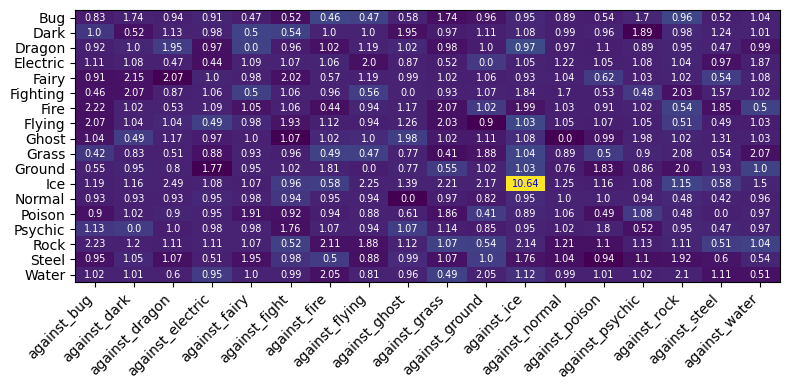

In [55]:
np_matrix = avg_against_df.to_numpy()

fig, ax = plt.subplots()

ax.imshow(np_matrix, aspect='auto')

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(elements)):
    for j in range(len(against_columns)):
        val = np_matrix[i, j]
        if val < 5:
            coloring = 'w'
        else:
            coloring = 'b'
        ax.text(i, j, val, color=coloring, ha='center', va='center', fontsize=7)
        
fig.tight_layout()
plt.show()

**Erschrecken Sie nicht!** Wir werden alles Stück für Stück durchgehen und verständlich machen!

## Aufbau eines Plots

Jedes Matplotlib-Objekt können Sie sich vorstellen wie eine Leinwand. Die Leinwand selbst, also Größe und Seitenverhältnisse sind das sog. `plt.figure`-Objekt. Dieses wiederum kann in ein oder mehrere Bereiche (Subplots - ähnlich einer zweidimensionalen Matrix) eingeteilt werden. Diese Bereiche bestehen dann aus sog. `plt.axes`-Objekten. Ein `axes`-Objekt selbst wieder zerfällt in mehrere Elemente: da wäre der eigentliche Plot, die Striche (ticks) der Achsenbeschriftung, die Label der einzelnen Ticks, ein Titel für jede Achse, eine Titel für den Subplot und eine Legende. Auch Textelemente können sich frei in einem `axes`-Objekt befinden.

Folgende Grafik mag dies veranschaulichen:

![Matplotlib Aufbau](../imgs/matplotlib_figure.png)

Um die oben erwähnten `figure` und `axes` Objekte "in einem Rutsch" zu generieren, bedienen wir uns der Hilfsfunktion `plt.subplots()`, die ein Tupel an `figure` und `axes` Objekten zurückgibt. Durch Python [Destructuring](https://blog.teclado.com/destructuring-in-python/) können wir die Teile dieses Tupels in Variablen speichern. Sinnvollerweise benennt man diese beiden konventionell `fig` und `ax` bzw. `axs` bei mehreren Achsen. Der Methode `plt.subplots()` selbst können wir einen Werte für Zeilen und Spalten übergeben, in die wir die Subplots unterteilen wollen.

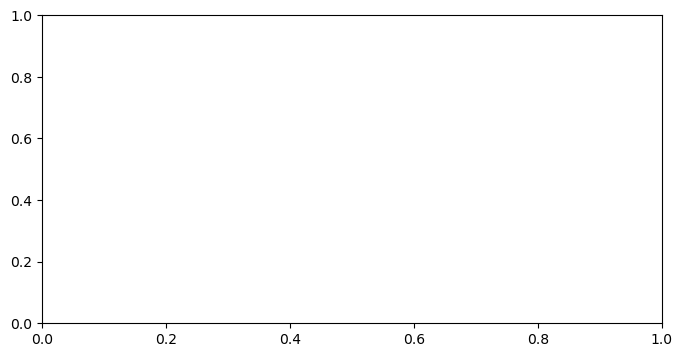

In [56]:
fig, ax = plt.subplots()

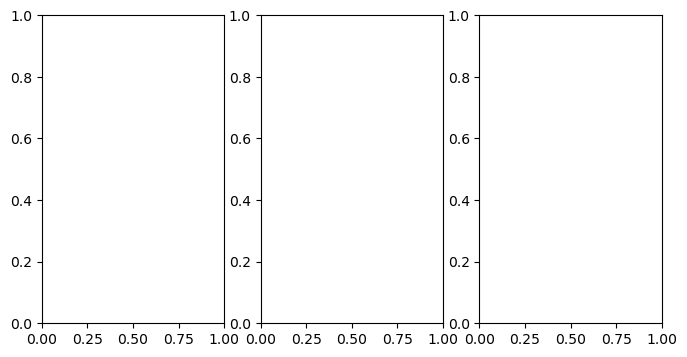

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

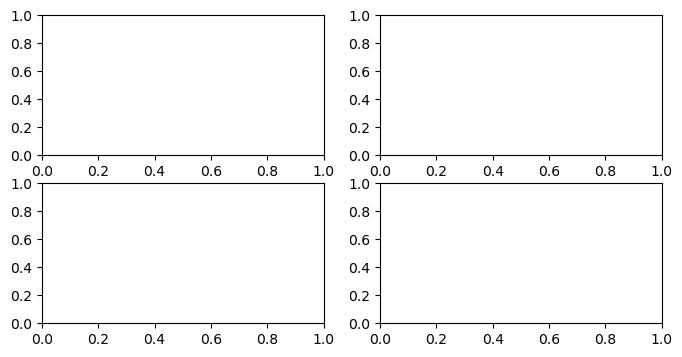

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

## Verschiedene Plottypen

Jedem `axes` Objekt kann ein bestimmter Plottyp übergeben werden. Welche Typen es gibt, finden sie in der Dokumentation, vor allem in der [Beispiel Sektion](https://matplotlib.org/stable/gallery/index.html), aus der ich selbst wertvolle Anregungen geschöpft habe. Nennenswert ist auch noch die [Python-Graph-Gallery](https://www.python-graph-gallery.com/), in der man viele nützliche Anregungen findet.

Hier nur ein kleines Beispiel und der Hinweis auf die Möglichkeit, mehrere Plots in einem Objekt zu überlagen, wenn man die Plot-Funktion öfter aufruft:

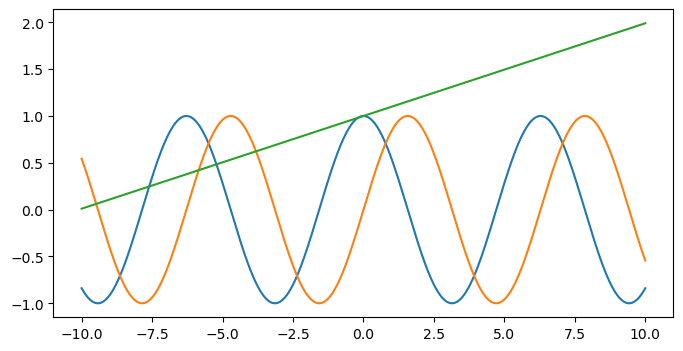

In [59]:
x_axis = np.linspace(-10, 10, 1000)
y_axis_cos = np.cos(x_axis)
y_axis_sin = np.sin(x_axis)
y_axis_line = np.array([x * 0.099 + 1 for x in x_axis])

fig, ax = plt.subplots()

ax.plot(x_axis, y_axis_cos)
ax.plot(x_axis, y_axis_sin)
ax.plot(x_axis, y_axis_line)

plt.show()

## Heatmap - plt.imshow()

Mit welchem Plottyp können wir nun unsere Heatmap generieren? Hierfür hält Pyplot die Funktion `.imshow()` bereit. Dieser Methode kann man einen NumPy Array aus numerischen Werten übergeben. Aus dem Min- und dem Max-Wert dieses Arrays "baut" die Funktion im Hintergrund eine kontinuierliche Farbskala (min = dunkle Werte / max = helle Werte). Jeder Wert im Array wird dann mit entsprechenden Wert auf der Farbskala "eingefärbt".

[[12 56 86 83 99 47 67]
 [54 75 67 41 77 62 18]
 [69 99 13 36 20 38 91]
 [58 84 88 86 99 96 32]
 [89 22 31  9 61  2 71]
 [12 93 61 24 49 25 91]
 [ 6 66 83  1 42 48 13]]


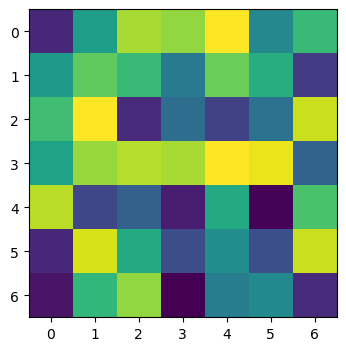

In [60]:
random_nums = np.random.randint(0, 100, size=49).reshape(7, 7)

print(random_nums)

fig, ax = plt.subplots()

ax.imshow(random_nums)
plt.show()

Um dies auch bei unserer Matrix zu machen, müssen wir diese erst in einen NumPy Array umwandeln. Wie wir dies machen, haben wir weiter oben schon gesehen: wir rufen einfach die Methode `.to_numpy()` auf.

In [61]:
np_matrix = avg_against_df.to_numpy()

Dann können wir diesen Array an `plt.imshow()` übergeben.

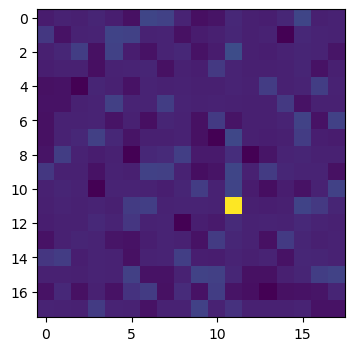

In [62]:
fig, ax = plt.subplots()

ax.imshow(np_matrix)
plt.show()

Schon hier sehen wir den hell leuchtenden Punkt, der uns darauf hinweist, dass wir es hier mit einem Ausreißer zu tun haben. Alle anderen Farben sehen sehr ebenmäẞig aus und deuten auf ein ausbalanciertes Design hin.

Wo aber genau liegt nun dieser Ausreiẞer? Um welches Element handelt es sich? Wir sollten die Namen der Elemente und der Spalten als Achsenbeschriftungen (*ticklabels*) hinzufügen. Dies können wir mit den beiden Achsen Methoden `.set_xticks()` respektive `.set_yticks()` machen. Dabei müssen wir ihnen eine Liste, oder einen Array an Werten übergeben, wo welche Ticks auf der Achse erscheinen sollen und können darüber noch über den Parameter "labels" eine Liste an Namen für die Ticks vergeben.

Wie bekommen wir nun am schnellsten, und vor allem am genauesten die Liste/ den Array an Werten für X- und Y-Achse?

Die Funktion `len()` gibt ja bekanntermaẞen die Anzahl an Elementen in einer Sequenz, also einem Python Iterable wider. Die NumPy Funktion `np.arange(<Zahl>)` wiederum gibt eine Liste von 0 bis "Zahl minus 1" zurück.

In [63]:
my_string = "Wie viele Zeichen hat dieser String?"

len(my_string)

36

In [64]:
np.arange(len(my_string))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

Dies können wir nutzen um die Ticks für X- und Y-Achse zu produzieren und ihnen gleichzeitig die Labels mitzugeben.

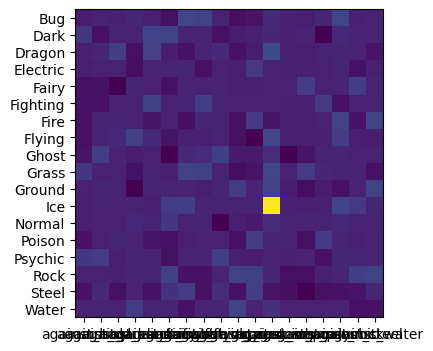

In [65]:
fig, ax = plt.subplots()

ax.imshow(np_matrix)

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns) # neu!
ax.set_yticks(np.arange(len(elements)), labels=elements)               # neu!

plt.show()

Was die Y-Achse betrifft, sieht das schon ganz gut aus, aber da die Labels bei Matplotlib standardmäẞig horizontal orientiert sind, müssen wir sie zuerst "drehen", am besten in einem "schrägen" Winkel von 45 Grad.

Hierzu gibt es mehrere Möglichkeiten. Allerdings hat das Pyplot Modul eine globale Möglichkeit der Konfiguration eines Plots mit Hilfe der Methode `.setp()`. Dieser übergibt man das Objekt, das man verändern möchte, gefolgt von Parametern, *was* verändert werden soll.

Gut, dass jedes Achsen-Objekt in Pyplot eine Methode namens `.get_…()` hat, die bestimmte Objekte zurückgibt. Wir brauchen hier die Variante `.get_xticklabels()`, was uns genau das Objekt der Ticklabels der X-Achse zurückgibt, welcher wir dann wieder an `.setp()` übergeben können. Als Parameter stellen wir ein: "rotation" und "ha" (= horizontal alignment).

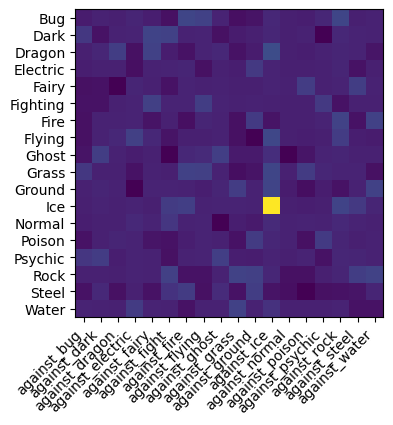

In [66]:
fig, ax = plt.subplots()

ax.imshow(np_matrix)

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right') # neu!

plt.show()

Dies sieht schon viel leserlicher aus! Und wir sehen endlich, dass es sich beim Ausreiẞer um einen enormen Nachteil handelt, wenn Eis-Elemente auf andere Eis-Elemente treffen. Aber wie hoch ist hier der Mittelwert? Klar, wir könnten oben in der Ausgabe des DataFrames nachsehen, aber besser wäre doch, wir sähen die Werte direkt in unserer Heatmap.

Dazu müssen wir wieder eine kleine zweifache For-Schleife schreiben (ich hoffe, Sie erkennen das Muster bei zweidimensionalen Datenstrukturen!). Wir wollen mit der Methode `ax.text()` in jeder Zelle einen Achsentext setzen. `ax.text()` muss man mindestens die drei Parameter *X-Position*, *Y-Position* und *Wert für den Text* mitgeben. In unserem Fall sind das ja für X- und Y-Position die gleichen Werte, die wir für die Achsen haben. Den Wert für den Text selbst finden wir in der NumPy Matrix.

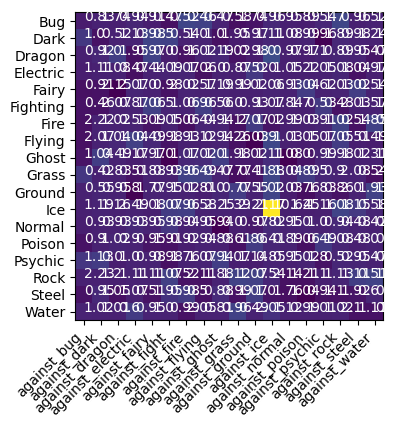

In [67]:
fig, ax = plt.subplots()

ax.imshow(np_matrix)

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(elements)):             #
    for j in range(len(against_columns)):  #
        val = np_matrix[i, j]              # neu!
        ax.text(i, j, val, color='w')      #

plt.show()

Die Werte stehen nun als Text in den Zellen. Aber ohje, der Text ist viel zu breit und groẞ und passt nicht ganz in die Zellen.

Wir können das Verhältnis der Zellen ändern, indem wir der Funktion `plt.imshow()` einen anderen Wert für den Parameter "aspect" mitgeben. Normalerweise achtet `.imshow()` darauf, dass die Zellen quadratisch sind. Setzen wir aber den Wert auf "auto", so passt sich die Breite der Zelle der Breite des Inhalts, aslo des Textes an.

Ausserdem wollen wir den Text generell etwas kleiner machen und ihn sowohl horizontal, als auch vertikal in der Zelle zentrieren. Dies können wir erreichen, indem wir in der Funktion `ax.text()` die Parameter "fontsize" (= Schriftgröẞe), "ha" (= horizontal align) und "va" (= vertical align) ändern.

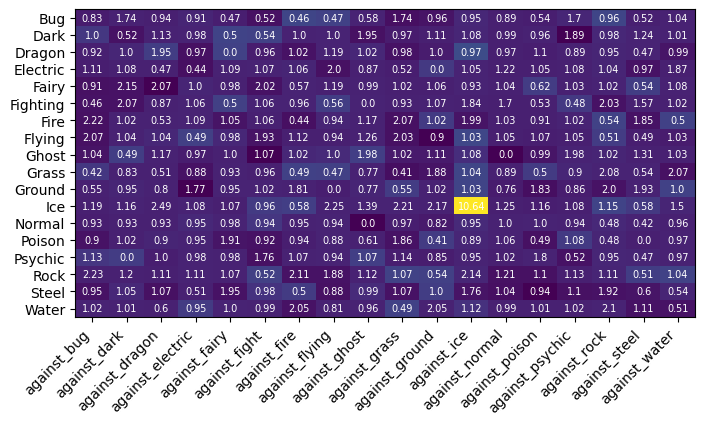

In [68]:
fig, ax = plt.subplots()

ax.imshow(np_matrix, aspect='auto')    # neuer Parameter!

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(elements)):             
    for j in range(len(against_columns)): 
        val = np_matrix[i, j]              
        ax.text(i, j, val, color='w', ha='center', va='center', fontsize=7)  # neue Parameter!

plt.show()

Der letzte kleine Wermutstropfen ist nun, dass man den Text in unserer "Ausreisser-Zelle" kaum lesen kann, da wir die Textfarbe auf `'w'` also "weiẞ" gestzt haben, man diese aber auf dem hellen Gelb kaum sehen kann. Da die Werte von 0 (= sehr dunkel) bis 10 (= sehr hell) coloriert werden, sollten wir eine Bedingung einbauen: wenn der Wert unter 5 liegt und damit tendenziell dunkel ist, soll als Textfarbe Weiẞ verwendet werden, in allen anderen Fällen aber Blau.

Solche "wenn X dann Y anderenfalls Z"-Bedingungen setzt man in Python mit einem sog. `if`-`else`-Statement um:

-----------
### Exkurs 4: Konditionale in Python

`if`-`else`-Statements sind in Python syntaktisch leicht umzusetzen:

```
if <Bedingung, die True oder False ergeben muss>:

    # Code Block, der bei True ausgeführt wird
    
else:

    # Code Block, der bei False ausgeführt wird
```

In [69]:
for i in range(1, 10):
    
    if i % 2 == 0:
        
        print(i, "ist gerade")
        
    else:
        
        print(i, "ist ungerade")

1 ist ungerade
2 ist gerade
3 ist ungerade
4 ist gerade
5 ist ungerade
6 ist gerade
7 ist ungerade
8 ist gerade
9 ist ungerade


-------

So können wir nun die Bedingung in unseren Code einbauen, dass die Farbe, wenn der Wert unter 5 liegt weiẞ, anderenfalls aber blau sein soll.

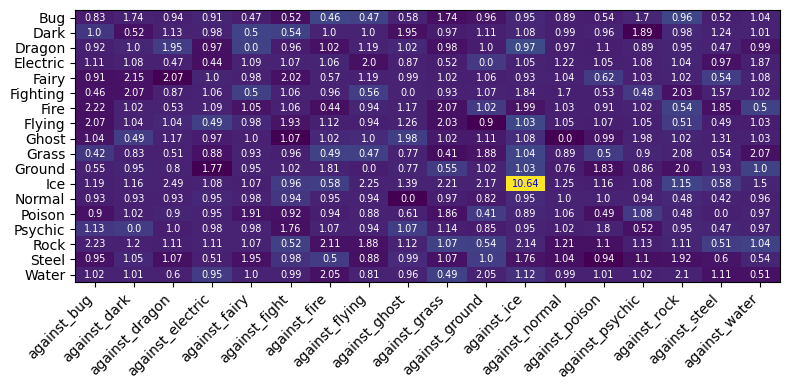

In [70]:
fig, ax = plt.subplots()

ax.imshow(np_matrix, aspect='auto')

ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(elements)):
    for j in range(len(against_columns)):
        
        val = np_matrix[i, j]
        
        if val < 5:              #
            coloring = 'w'       # neuer Code!
        else:                    #
            coloring = 'b'       #
            
        ax.text(i, j, val, color=coloring, ha='center', va='center', fontsize=7) # Parameter geändert!
        
fig.tight_layout()
plt.show()

Zum Schluss wollen wir noch die nötigen erklärenden Titel für den Plot und für die einzelnen Achsen hinzufügen.

In [ ]:
# 

Voilá, unser Code ist fertig. Aber es hat uns einiges an Mühe gekostet! 😥

Gibt es nicht eine einfachere Möglichkeit, solche Plots mit Matplotlib zu erstellen? Ja gibt es! Wir wollen uns daher ganz kurs das Modul **Seaborn** ansehen und wie wir damit eine ähnliche vielleicht sogar schönere Heatmap erstellen können.

### Einen Outlier suchen und korrigieren

**Zuerst** wollen wir aber noch den Ausreisser finden und unter Umständen korrigieren.

In [71]:
mask = df['type_1'] == 'Ice'
column_list = ['pokedex_number', 'name', 'german_name', 'against_ice']

ice_df = df[mask][column_list]

In [72]:
ice_df.shape

(37, 4)

In [73]:
ice_df['against_ice'].value_counts()

0.50      26
1.00       5
0.25       3
125.00     3
Name: against_ice, dtype: int64

Drei Einträge haben einen Wert in 'against_ice' von 125. Kann das ein Tippfehler sein? Sehr wahrscheinlich ist 1.25 gemeint!

Um welches Pokemon handelt es sich?

In [74]:
outlier = ice_df[ice_df['against_ice'] == 125]

outlier

,pokedex_number,name,german_name,against_ice
436,363,Spheal,Seemops,125.0
437,364,Sealeo,Seejong,125.0
438,365,Walrein,Walraisa,125.0


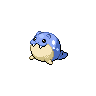

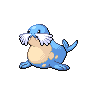

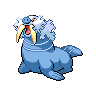

In [75]:
for poke_num in outlier['pokedex_number']:
    display(Image(get_poke_image(poke_num)))

Wir ändern die Werte in 1.25.

In [76]:
for index in list(outlier.index):
    df.at[index, 'against_ice'] = 1.25

### .at und .iat

Warum haben wir die Methode `.at` verwendet? Hätten wir `.loc` oder `.iloc` verwendet so hätten wir nur einen sog. *View* des DataFrames erhalten. Doch dieser View ist eben nur eine Ansicht, in der wir nichts verändern können. Damit wir einzelne Werte in einem DataFrame verändern (in Programiersprache "setten") können, gibt uns Pandas die Funktionen `.iat` und `.at` mit auf den Weg, die genauso funktionieren wie `.iloc` und `.loc`. Man übergibt ihnen also auch entweder eine Indexnummer oder den Namen einer Spalte oder einer Zeile. Man sollte sie aber, da Sie ja den Datensatz direkt verändern nur mit bedacht benutzen!

In [77]:
df.loc[436:438, 'against_ice']

436    1.25
437    1.25
438    1.25
Name: against_ice, dtype: float64

## Die Heatmap mit der Hilfe von Seaborn

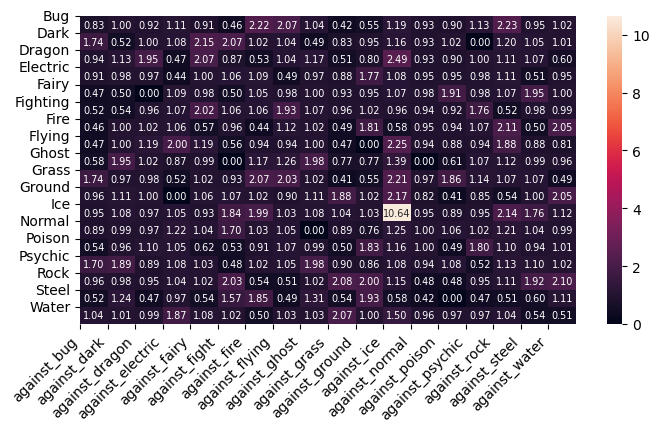

In [78]:
import seaborn as sns

ax = sns.heatmap(np_matrix, fmt=".2f", annot=True, annot_kws={'fontsize': 7})
ax.set_xticks(np.arange(len(against_columns)), labels=against_columns)
ax.set_yticks(np.arange(len(elements)), labels=elements)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## Korrelation mit sns.lmplot

Was die Vor- und Nachteile der Elemente gegeneinander betrifft, so scheint das Spiel über alle Generationen hinweg sehr gut ausbalanciert zu sein. Aber gibt es keine Eigenschaft eines Pokemons, das eventuell Einfluss auf seine Chance zu gewinnen hat? Die Frage ist also: gibt es Eigenschaften, die mit der Win-Rate korrelieren?

Wir schauen uns zuerst einmal die verdächtigen Kandidaten an, nämlich Eigenschaften, die die Stärke oder die Verteidigung eines Pokemon "in Zahlen gieẞen". Wir nehmen sicherheitshalber noch Gewicht, Gröẞe und Lebenspunkte dazu.

In [79]:
combat_stats = ['height_m', 'weight_kg', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'win_rate']

df[combat_stats].corr()

,height_m,weight_kg,hp,attack,defense,sp_attack,sp_defense,speed,win_rate
height_m,1.000000,0.649098,0.374797,0.205505,0.305927,0.202550,0.308383,0.137067,0.243217
weight_kg,0.649098,1.000000,0.440053,0.426925,0.469833,0.236694,0.302330,0.049318,0.160364
hp,0.374797,0.440053,1.000000,0.443752,0.299977,0.371185,0.392835,0.189705,0.246602
attack,0.205505,0.426925,0.443752,1.000000,0.456565,0.369529,0.266685,0.373712,0.478849
defense,0.305927,0.469833,0.299977,0.456565,1.000000,0.222737,0.544896,0.004664,0.119214
sp_attack,0.202550,0.236694,0.371185,0.369529,0.222737,1.000000,0.510727,0.445268,0.478123
sp_defense,0.308383,0.302330,0.392835,0.266685,0.544896,0.510727,1.000000,0.226562,0.331574
speed,0.137067,0.049318,0.189705,0.373712,0.004664,0.445268,0.226562,1.000000,0.923838
win_rate,0.243217,0.160364,0.246602,0.478849,0.119214,0.478123,0.331574,0.923838,1.000000


Uns interessiert aber vor allem die unterste Zeile ohne die letzte Spalte:

In [80]:
win_rate_corr = df[combat_stats].corr().iloc[-1, :-1]

win_rate_corr

height_m      0.243217
weight_kg     0.160364
hp            0.246602
attack        0.478849
defense       0.119214
sp_attack     0.478123
sp_defense    0.331574
speed         0.923838
Name: win_rate, dtype: float64

Scheinbar gibt es vor allem zwischen dem Speed eines Pokemon und der Win-Rate eine sehr hohe Korrelation von .92. Das sieht man auch an einem Plot sehr gut:

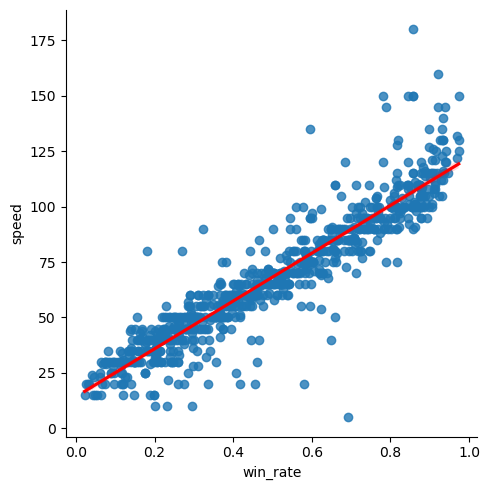

In [81]:
sns.lmplot(data=df, x='win_rate', y='speed', line_kws={'color': 'red'})
plt.show()

Hier haben wir Seaborn dazu benutzt, über die Methode `.lmplot` ein lineares Regressionsmodell über die Variablen X und Y zu bilden und zu plotten. Seaborn liefert die Regressionslinie und ein Konfidenzintervall, das standardmäẞig auf .95 eingestellt ist gleich mit.

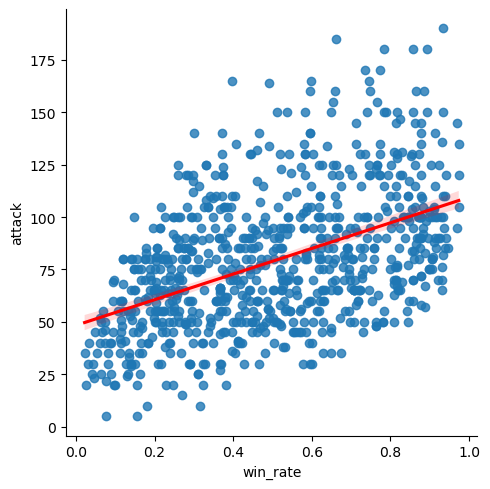

In [82]:
sns.lmplot(data=df, x='win_rate', y='attack', line_kws={'color': 'red'})
plt.show()

## Der "MATLAB"-Stil in Matplotlib

# Inferenzstatistik mit SciPy

[SciPy](https://scipy.org/) bietet Algorithmen für Optimierung, Integration, Interpolation, Eigenwertprobleme, algebraische Gleichungen, Differentialgleichungen, Statistik und viele andere Arten von Problemen.

Und interessiert uns hier aber vor allem das Submodul `stats`, das sowohl die Funktionalität für die Inferenzstatistik (p-values, t-tests, anovas) als auch verschiedene Möglichkeiten mit Wahrscheinlichkeitsverteilungen zu arbeiten. Einen Überblick verschafft Ihnen wie immer die sehr gute [Dokumentation](https://docs.scipy.org/doc/scipy/reference/stats.html).

Wir importieren es folgendermaẞen:

In [83]:
from scipy import stats

Sehen wir aber zuerst ob wir überhaupt Gruppenunterschiede analytisch in unserem Datensatz bezogen auf die Win-Rate eines Pokemons feststellen können. Anschlieẞend wollen wir diese Gruppenunterschiede dann inferenzstatistisch testen.

## Gruppenunterschiede mit .groupby und .agg

Zunächst wollen wir uns analytisch ein paar Gruppenunterschiede ansehen. Dazu verwenden wir die Pandas Methoden `.groupby()`, gefolgt von `.agg()`.

Was macht `.groupby()`?

In [84]:
df.groupby('status')

`.groupy()` kann man den Namen einer Spalte, oder eine Liste an Namen von Spalten übergeben und Pandas generiert daraus dann ein `GroupBy`-Objekt. Allerdings bringt uns dieses Objekt noch nicht viel. Wir müssen erst eine Methode dieses Objekts aufrufen, um zu sehen, was Pandas im Hintergrund gemacht hat.

In [85]:
status_group = df.groupby('status')

status_group.describe()

pokedex_number                                                \
                       count        mean         std    min     25%    50%   
status                                                                       
Legendary               42.0  628.333333  237.181794  150.0  408.75  716.5   
Mythical                30.0  584.333333  186.418205  151.0  489.25  647.0   
Normal                 918.0  418.314815  258.942093    1.0  193.25  409.5   
Sub Legendary           55.0  594.018182  247.097783  144.0  380.50  642.0   

                             generation                                      \
                  75%    max      count      mean       std  min   25%  50%   
status                                                                        
Legendary      800.00  898.0       42.0  5.333333  2.248758  1.0  3.25  6.0   
Mythical       720.00  893.0       30.0  4.833333  1.703613  1.0  4.00  5.0   
Normal         633.75  887.0      918.0  3.938998  2.250550  1.0  2.00  4.0   
Sub Legendary  796.50  897.0       55.0  5.418182  2.183193  1.0  4.00  5.0   

                        type_number                                           \
               75%  max       count      mean       std  min   25%  50%  75%   
status                                                                         
Legendary      7.0  8.0        42.0  1.738095  0.445001  1.0  1.25  2.0  2.0   
Mythical       6.0  8.0        30.0  1.566667  0.504007  1.0  1.00  2.0  2.0   
Normal         5.0  8.0       918.0  1.514161  0.500072  1.0  1.00  2.0  2.0   
Sub Legendary  7.0  8.0        55.0  1.600000  0.494413  1.0  1.00  2.0  2.0   

                   height_m  ... against_dark against_steel            \
               max    count  ...          max         count      mean   
status                       ...                                        
Legendary      2.0     42.0  ...          4.0          42.0  1.011905   
Mythical       2.0     30.0  ...          4.0          30.0  1.008333   
Normal         2.0    918.0  ...          2.0         918.0  0.978486   
Sub Legendary  2.0     55.0  ...          2.0          55.0  0.995455   

                                                    against_fairy            \
                    std   min    25%  50%  75%  max         count      mean   
status                                                                        
Legendary      0.461811  0.50  0.625  1.0  1.0  2.0          42.0  1.321429   
Mythical       0.852186  0.25  0.500  1.0  1.0  4.0          30.0  1.116667   
Normal         0.490518  0.00  0.500  1.0  1.0  4.0         918.0  1.070261   
Sub Legendary  0.477481  0.25  0.500  1.0  1.0  2.0          55.0  1.250000   

                                                  win_rate            \
                    std   min  25%  50%  75%  max    count      mean   
status                                                                 
Legendary      0.561155  0.50  1.0  1.0  2.0  2.0     22.0  0.794863   
Mythical       0.536324  0.50  1.0  1.0  1.0  2.0     22.0  0.823467   
Normal         0.516461  0.00  1.0  1.0  1.0  4.0    750.0  0.474975   
Sub Legendary  0.750000  0.25  1.0  1.0  2.0  4.0     31.0  0.760327   

                                                                           
                    std       min       25%       50%       75%       max  
status                                                                     
Legendary      0.085008  0.649351  0.742358  0.778719  0.859004  0.933649  
Mythical       0.102822  0.560606  0.819467  0.857500  0.877806  0.942149  
Normal         0.243029  0.021739  0.270004  0.459359  0.660377  0.973783  
Sub Legendary  0.179635  0.235714  0.688406  0.852459  0.873047  0.947368  

[4 rows x 304 columns]

In [86]:
status_group['win_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Legendary,22.0,0.794863,0.085008,0.649351,0.742358,0.778719,0.859004,0.933649
Mythical,22.0,0.823467,0.102822,0.560606,0.819467,0.857500,0.877806,0.942149
Normal,750.0,0.474975,0.243029,0.021739,0.270004,0.459359,0.660377,0.973783
Sub Legendary,31.0,0.760327,0.179635,0.235714,0.688406,0.852459,0.873047,0.947368


`.groupby()` generiert also ein Objekt, dass die einzigartigen Werte der übergebenen Spalte gruppiert (also im Falle der Spalte "status" eben die Werte "Legendary", "Mythical", "Normal" und " Sub Legendary". Wendet man nun eine Methode an, wie etwas `.describe()`, erhält man die Werte gruppiert je Element.

Mit der Methode `.agg()` (steht für engl. "to aggregate") kann man gezielter Aggregatsfunktionen auf Spalten der gruppiert Elemente anwenden. Allerdings ist `.agg` im Zusammenspiel mit `.groupby()` etwas komplex zu verwenden. Ich zeige hier nur zwei wichtige Möglichkeiten (weitere finden Sie in der [Dokumentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html)).

Sie können `.agg()` ein Python Dictionary übergeben, dass als Schlüssel die Spalten enthält und als Wert den Namen der Funktion, die auf diese Spalte ausgeführt werden soll:

In [87]:
df.groupby('type_1').agg({'win_rate': 'mean'}).sort_values(by='win_rate', ascending=False)

,win_rate
type_1,
Flying,0.770335
Electric,0.641101
Dragon,0.639346
Dark,0.634028
Fire,0.575293
Psychic,0.551195
Normal,0.535553
Ground,0.533090
Fighting,0.485958


In [88]:
df.groupby('status').agg({'win_rate': 'mean'}).sort_values(by='win_rate', ascending=False)

,win_rate
status,
Mythical,0.823467
Legendary,0.794863
Sub Legendary,0.760327
Normal,0.474975


In [89]:
df.groupby('generation').agg({'win_rate': 'mean'}).sort_values(by='win_rate', ascending=False)

,win_rate
generation,
4,0.539702
1,0.523607
5,0.515202
6,0.491622
3,0.484152
8,0.462686
2,0.449453
7,NaN


Übergeben wir an `.groupby()` eine Liste an Spaltennamen, so werden diese miteinander kombiniert:

In [90]:
df.groupby(['status', 'type_1']).agg({'win_rate': 'mean'}).sort_values(by='win_rate', ascending=False)

win_rate
status        type_1           
Mythical      Dark     0.940171
Legendary     Psychic  0.917450
Sub Legendary Flying   0.914163
Mythical      Grass    0.897233
Sub Legendary Grass    0.895161
...                         ...
Mythical      Poison        NaN
Sub Legendary Bug           NaN
              Fairy         NaN
              Ghost         NaN
              Poison        NaN

[72 rows x 1 columns]

Möchte man mehrere Aggregatsfunktionen auf eine Spalte anwenden, so muss man zuerst diese Spalte im `GroupBy`-Objekt auswählen.

```
<GroupByObject>['Spaltenname']
```

Nun, da klar ist, auf welche Spalte sich die Aggregationen beziehen sollen, kann man `.agg()` Tupel übergeben, deren erster Werte der Name der zu bezeichnenden (neuen) Spalte in der Ausgabe sein soll, und deren zweite Werte den Namen der Aggregatsfunktion enthalten.

In [91]:
(df.groupby('type_1')['win_rate']      # Auswahl nur einer Spalte
    .agg([('win_rate_mean', 'mean'),   # neue Spalte 'win_rate_mean' und Funktionsname 'mean'
          ('win_rate_std', 'std')])
    .sort_values(by='win_rate_mean', ascending=False))

,win_rate_mean,win_rate_std
type_1,,
Flying,0.770335,0.298602
Electric,0.641101,0.235231
Dragon,0.639346,0.219983
Dark,0.634028,0.220617
Fire,0.575293,0.231125
Psychic,0.551195,0.294536
Normal,0.535553,0.259128
Ground,0.533090,0.235292
Fighting,0.485958,0.252245


## t-tests über die Gruppen

Das Modul `stats` beinhaltet die Funktion `.ttest_ind()` für die Durchführung eines T-Tests bei unabhängigen Stichproben sowie der Funktion `.f_oneway()`, um eine ANOVA bei mehreren Gruppen durchzuführen.

In [92]:
pokemon_normal = df[(df['status'] == 'Normal') & ~(df['win_rate'].isna())]
pokemon_legendary = df[(df['status'] != 'Normal') & ~(df['win_rate'].isna())]

sample_normal = pokemon_normal.sample(70)
sample_legendary = pokemon_legendary.sample(70)

# unabhängiger T-Test ohne die Annahme gleicher Varianz zwischen den Samples
stats.ttest_ind(sample_normal['win_rate'], sample_legendary['win_rate'], equal_var=False)

Ttest_indResult(statistic=-9.832933121947555, pvalue=8.034618988594967e-17)

## ANOVA

### Prüfung auf Normalverteilung

#### Boxplot

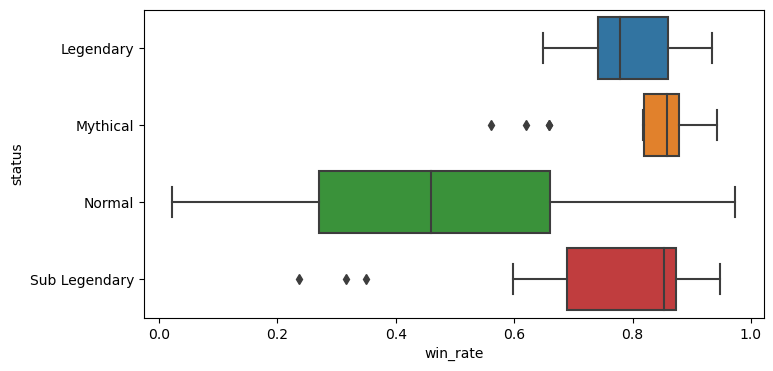

In [93]:
sns.boxplot(x='win_rate', y='status', data=df)

plt.show()

#### Histogramme

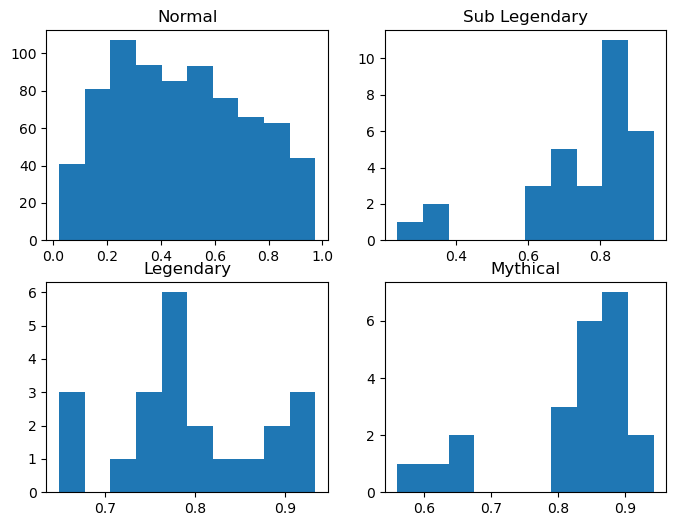

In [94]:
plt.rcParams["figure.figsize"] = (8, 6)
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)

ax0.hist(df[df['status'] == 'Normal']['win_rate'])
ax0.set_title("Normal")

ax1.hist(df[df['status'] == 'Sub Legendary']['win_rate'])
ax1.set_title("Sub Legendary")

ax2.hist(df[df['status'] == 'Legendary']['win_rate'])
ax2.set_title("Legendary")

ax3.hist(df[df['status'] == 'Mythical']['win_rate'])
ax3.set_title("Mythical")

plt.show()

#### Kolmogorov Smirnof Test

In [95]:
status_groups = df['status'].dtype.categories.to_list()
df_win = df[~df['win_rate'].isna()]

tests_ks = [stats.kstest(df_win[df_win['status'] == cat]['win_rate'], 'norm') for cat in status_groups]

for i in range(len(tests_ks)):
    
    print(f"{status_groups[i]}: Stat: {tests_ks[i].statistic} P: {tests_ks[i].pvalue}")

Legendary: Stat: 0.7419441226315994 P: 5.655467824107231e-13
Mythical: Stat: 0.712466940484226 P: 8.491102908180814e-12
Normal: Stat: 0.5121635266331699 P: 4.35025787309089e-183
Sub Legendary: Stat: 0.6284675735698025 P: 2.2370783403692963e-12


# Übungen

- Total	Compute the Pokemon type(s) that have highest average Total strength.
- HP	Compute the Pokemon type(s) that have highest average HP.
- Attack	Compute the Pokemon type(s) that have highest average Attack.
- Defense	Compute the Pokemon type(s) that have highest average Defense.
- SpecialAttack	Compute the Pokemon type(s) that have highest average Special Attack.
- SpecialDefense	Compute the Pokemon type(s) that have highest average Special Defense.
- Speed	Compute the Pokemon type(s) that have highest average Speed.